In [1]:
import numpy as np 
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
im1 = np.array(Image.open("im01.jpg")).astype("double")
im2 = np.array(Image.open("im02.jpg")).astype("double")

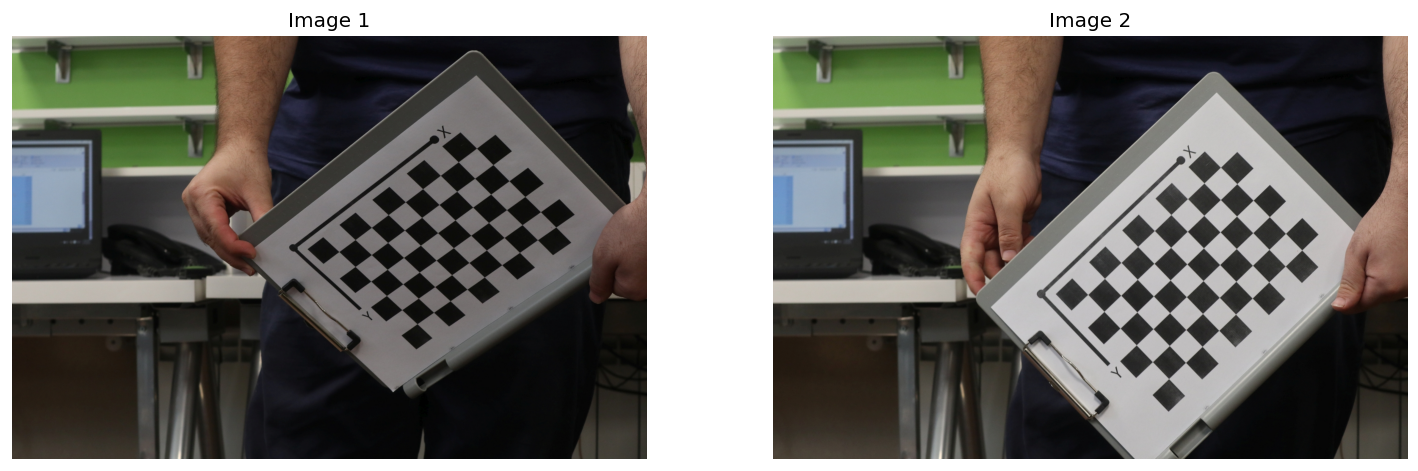

In [3]:
plt.figure(dpi=120,figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(im1.astype("uint8"))
plt.axis("off")
plt.title("Image 1")

plt.subplot(1,2,2)
plt.imshow(im2.astype("uint8"))
plt.axis("off")
plt.title("Image 2")
plt.show()

## Part 1: Finding the edges

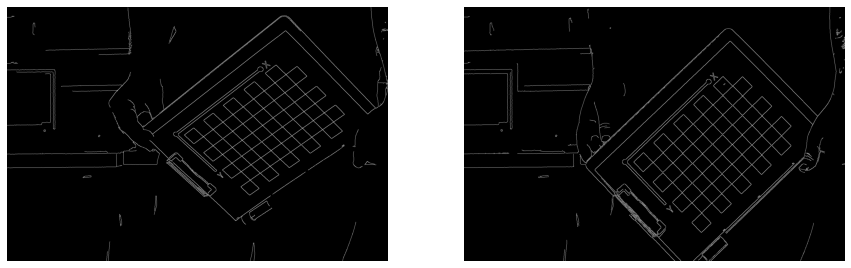

In [4]:
# in order to find edges I used the preimplemented canny edge detector
# I changed the thresholds manually to find the best results 
edge1 = cv.Canny(image = im1.astype("uint8"), threshold1 = 80, threshold2 = 200)
edge2 = cv.Canny(image = im2.astype("uint8"), threshold1 = 80, threshold2 = 200)
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.axis("off")
plt.imshow(edge1,cmap='gray');
plt.subplot(1,2,2)
plt.axis("off")
plt.imshow(edge2,cmap='gray');

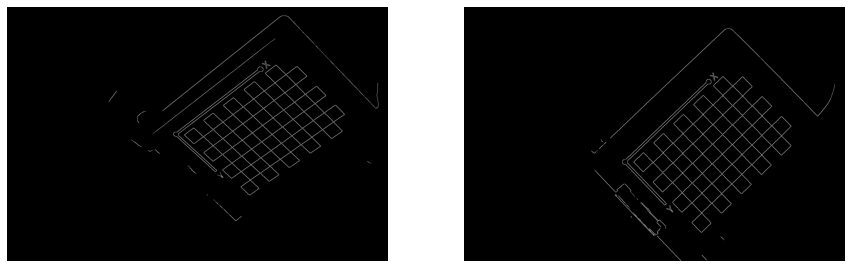

In [5]:
# if we only want to detect the edges of the black and white board then we use these thresholds
edge1 = cv.Canny(image = im1.astype("uint8"), threshold1 = 370, threshold2 = 540)
edge2 = cv.Canny(image = im2.astype("uint8"), threshold1 = 370, threshold2 = 540)
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.axis("off")
plt.imshow(edge1,cmap='gray');
plt.subplot(1,2,2)
plt.axis("off")
plt.imshow(edge2,cmap='gray');

In [6]:
Image.fromarray(edge1).save("results/res01.jpg", "JPEG")
Image.fromarray(edge2).save("results/res02.jpg", "JPEG")

## Part 2: Hough Transform

In [7]:
def hough_transform(im, dtheta = 0.5, dr = 5):
    '''This function gets an image "im" and the difference between each quantization level in theta and r and finds
    the equivalent image in hough space'''
    m,n = im.shape
    r_max = (m**2 + n**2)**0.5
    m_out = 2 * int(r_max / dr) + 1
    n_out = int(np.pi // (dtheta * np.pi / 180) + 1)
    out = np.zeros((m_out, n_out))
    for i in range(m):
        for j in range(n):
            if (im[i,j] == 255):
                k = np.arange(0,n_out)
                theta = (k * dtheta - 90) * np.pi/180
                rho = i * np.cos(theta) + j * np.sin(theta)
                l = (np.floor(rho / dr) + np.floor(r_max / dr) + 1).astype("int")
                out[l,k] = out[l,k] + 1
    return out

In [8]:
dtheta = 0.5
dr = 5
hough1 = hough_transform(edge1, dtheta, dr)
hough2 = hough_transform(edge2, dtheta, dr)

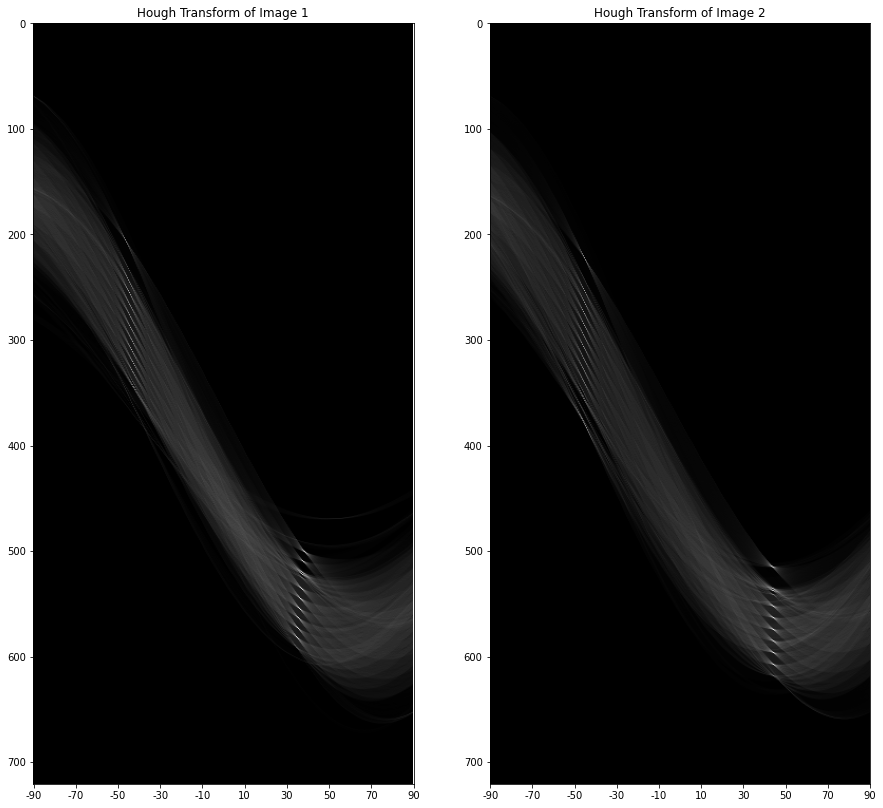

In [9]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(hough1, cmap="gray")
locs = np.linspace(0,hough1.shape[1],10).astype("int")
values = (locs * dtheta - 90).astype("int")
plt.xticks(locs, values)
plt.title("Hough Transform of Image 1")
plt.subplot(1,2,2)
plt.imshow(hough2, cmap="gray")
locs = np.linspace(0,hough2.shape[1],10).astype("int")
values = (locs * dtheta - 90).astype("int")
plt.xticks(locs, values)
plt.title("Hough Transform of Image 2")

plt.show()

In [10]:
Image.fromarray(np.round_(hough1/hough1.max()*255).astype("uint8")).save("results/res03-hough-space.jpg", "JPEG")
Image.fromarray(np.round_(hough2/hough2.max()*255).astype("uint8")).save("results/res04-hough-space.jpg", "JPEG")

## Part 3: Drawing Lines and Detecting the Chess Board

In [11]:
def line_drawer(im, hough, dtheta, dr, color = (255,0,0), thickness = 2):
    '''This functions gets the original image, its thresholded hough transform and some line properties and returns
    the image with lines on it'''
    m_hough, n_hough = hough.shape
    m,n,_ = im.shape
    locs = np.where(hough == 1)
    locs = list(zip(locs[0], locs[1]))
    out = im.copy()
    pts = []
    for loc in locs:
        rho = (loc[0]-(m_hough - 1)//2)* dr
        theta = (loc[1]*dtheta - 90) * np.pi / 180
        x = rho / np.cos(theta)
        y = rho / np.sin(theta)
        if (x>=0 and y>=0):
            out = cv.line(out, (0,int(x)), (int(y),0), color, thickness)
        elif (x<=0 and y>=0):
            x = (rho - (n-1) * np.sin(theta)) / np.cos(theta)
            out = cv.line(out, (int(y),0), (n-1,int(x)), color, thickness)
        elif (x>=0 and y<=0):
            y = (rho - (m-1) * np.cos(theta)) / np.sin(theta)
            out = cv.line(out, (0,int(x)), (int(y),m-1), color, thickness)
        pts.append((x,y))
    return out.astype("uint8")

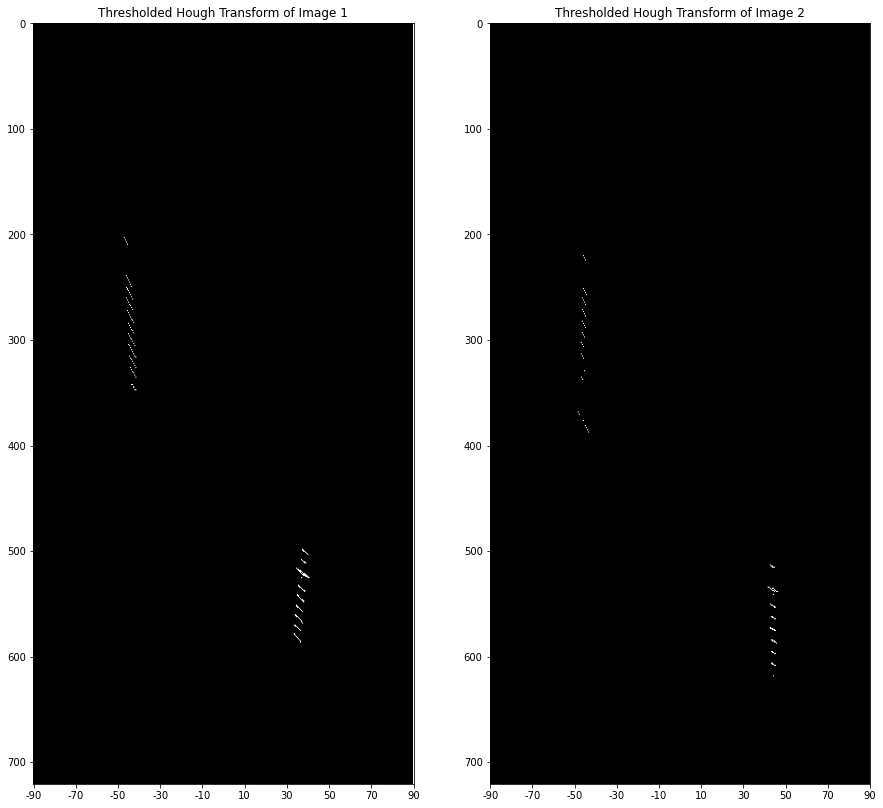

In [12]:
# if we just do a simple thresholding we reach this answer
hough1_thresholded = np.zeros(hough1.shape)
hough1_thresholded[hough1 > 300] = 1

hough2_thresholded = np.zeros(hough2.shape)
hough2_thresholded[hough2 > 400] = 1

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(hough1_thresholded, cmap="gray")
locs = np.linspace(0,hough1.shape[1],10).astype("int")
values = (locs * dtheta - 90).astype("int")
plt.xticks(locs, values)
plt.title("Thresholded Hough Transform of Image 1")
plt.subplot(1,2,2)
plt.imshow(hough2_thresholded, cmap="gray")
locs = np.linspace(0,hough2.shape[1],10).astype("int")
values = (locs * dtheta - 90).astype("int")
plt.xticks(locs, values)
plt.title("Thresholded Hough Transform of Image 2")

plt.show()

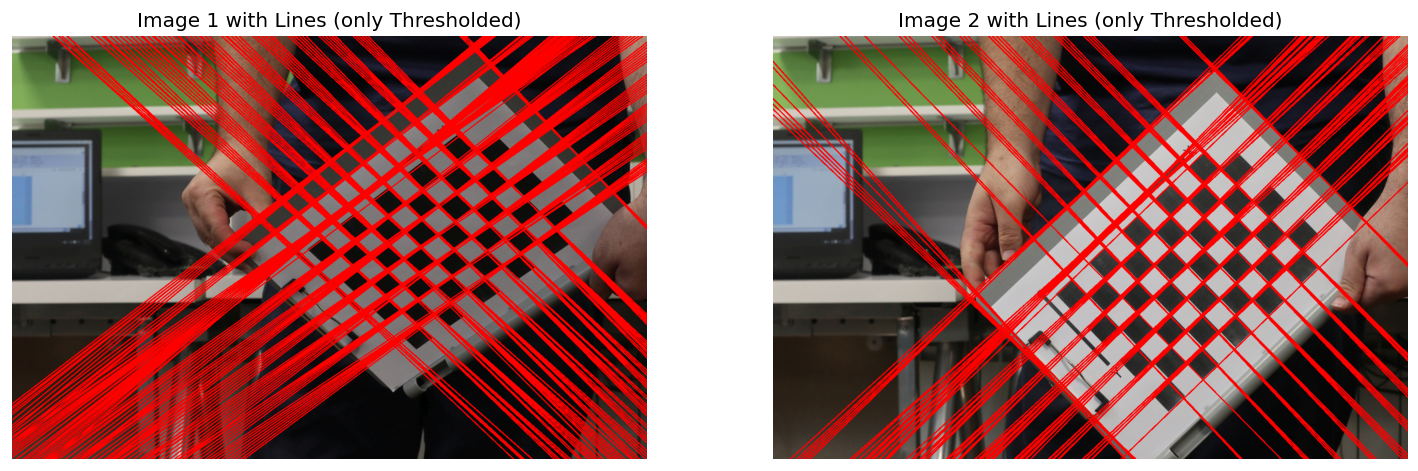

In [13]:
out1= line_drawer(im1, hough1_thresholded, dtheta, dr)
out2= line_drawer(im2, hough2_thresholded, dtheta, dr)

plt.figure(dpi=120,figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(out1.astype("uint8"))
plt.axis("off")
plt.title("Image 1 with Lines (only Thresholded)")

plt.subplot(1,2,2)
plt.imshow(out2.astype("uint8"))
plt.axis("off")
plt.title("Image 2 with Lines (only Thresholded)")
plt.show()

As can be seen, the results are not satisfying at all. What should we do instead is to first apply a maximum checker window which checks if the given pixel has the maximum value in comparison with its surroundings and then we should use thresholding.

In [14]:
def max_window(im, window_size = (5,5)):
    '''This function checks if on a window the point has the maximum value or not, if yes it saves its value and if
    not, it substitutes the pixel's value with 0'''
    m,n = im.shape
    out = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            is_max = True
            for k in range(max(0, i - window_size[0]//2), min(i + (window_size[0]+1)//2, m - 1)):
                for l in range(max(0, j - window_size[1]//2), min(j + (window_size[1]+1)//2, n - 1)):
                    if (im[k,l] > im[i,j]):
                        is_max = False
            if (is_max):
                out[i,j] = im[i,j]
    return out

In [15]:
# Max windowing the hough transforms
hough1_max_windowed = max_window(hough1, (7,7))
hough2_max_windowed = max_window(hough2, (7,7))

In [16]:
# Thresholding the max windowed values
hough1_thresholded = np.zeros(hough1_max_windowed.shape)
hough1_thresholded[hough1_max_windowed > 410] = 1

hough2_thresholded = np.zeros(hough2_max_windowed.shape)
hough2_thresholded[hough2_max_windowed > 400] = 1

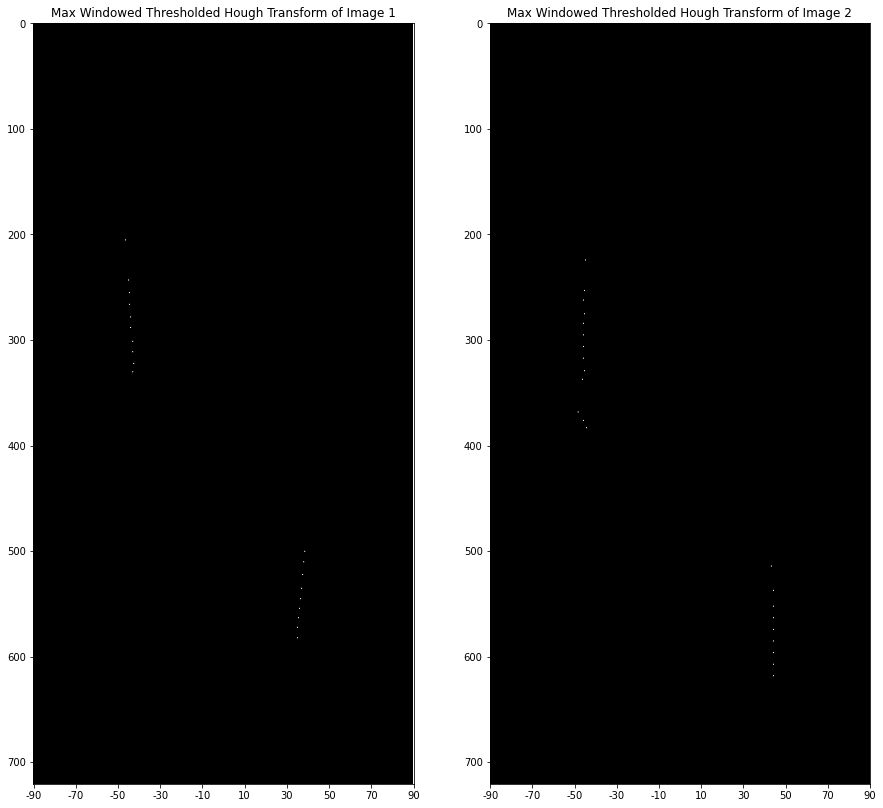

In [17]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(hough1_thresholded, cmap="gray")
locs = np.linspace(0,hough1.shape[1],10).astype("int")
values = (locs * dtheta - 90).astype("int")
plt.xticks(locs, values)
plt.title("Max Windowed Thresholded Hough Transform of Image 1")
plt.subplot(1,2,2)
plt.imshow(hough2_thresholded, cmap="gray")
locs = np.linspace(0,hough2.shape[1],10).astype("int")
values = (locs * dtheta - 90).astype("int")
plt.xticks(locs, values)
plt.title("Max Windowed Thresholded Hough Transform of Image 2")

plt.show()

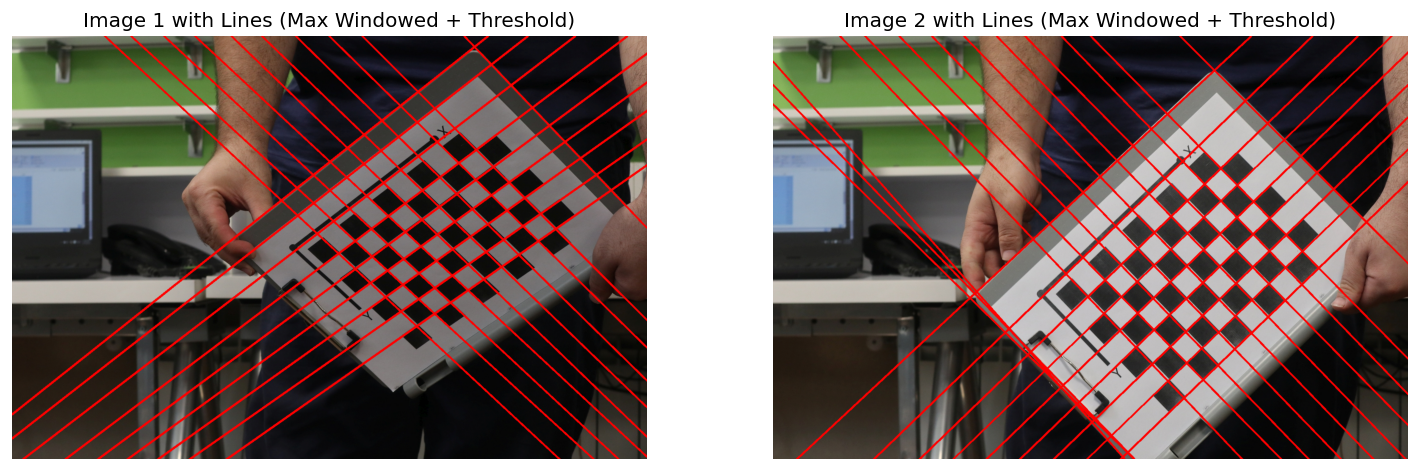

In [18]:
out1= line_drawer(im1, hough1_thresholded, dtheta, dr, color=(255,0,0), thickness=4)
out2= line_drawer(im2, hough2_thresholded, dtheta, dr, color=(255,0,0), thickness=4)

plt.figure(dpi=120,figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(out1.astype("uint8"))
plt.axis("off")
plt.title("Image 1 with Lines (Max Windowed + Threshold)")

plt.subplot(1,2,2)
plt.imshow(out2.astype("uint8"))
plt.axis("off")
plt.title("Image 2 with Lines (Max Windowed + Threshold)")
plt.show()

In [19]:
Image.fromarray(out1.astype("uint8")).save("results/res05-lines.jpg", "JPEG")
Image.fromarray(out2.astype("uint8")).save("results/res06-lines.jpg", "JPEG")

For now, the results are ok but in the first image, 4 extra lines are detected and the sides of the chess board are also not detected. In the same way, the second image also has 6 extra lines without the sides detected. What we should do now is to remove the extra lines and insert the side lines.

For the first image, we approximately have two different angles. In one of the angles we should remove the three lines with the lowest $\rho$ and for the second angle we should remove the line with the highest $\rho$. The process is the same for the second image.

In [20]:
# getting the points with a 1 value
r_max = (im1.shape[0]**2 + im1.shape[1]**2)**0.5
locs = np.where(hough1_thresholded == 1)
locs_tuple = list(zip(locs[0] * dr - r_max, locs[1] * dtheta - 90))
locs_tuple

[(-777.7756377319947, -46.5),
 (-587.7756377319947, -45.0),
 (-527.7756377319947, -44.5),
 (-472.7756377319947, -44.5),
 (-412.7756377319947, -44.0),
 (-362.7756377319947, -44.0),
 (-297.7756377319947, -43.0),
 (-247.77563773199472, -43.0),
 (-192.77563773199472, -42.5),
 (-152.77563773199472, -43.0),
 (697.2243622680053, 38.5),
 (747.2243622680053, 38.0),
 (807.2243622680053, 37.5),
 (872.2243622680053, 37.0),
 (922.2243622680053, 36.5),
 (967.2243622680053, 36.0),
 (1012.2243622680053, 35.5),
 (1057.2243622680053, 35.0),
 (1107.2243622680053, 35.0)]

In [21]:
# removing the mentioned lines
locs_r = np.delete(locs[0],[0,10,11,12])
locs_theta = np.delete(locs[1],[0,10,11,12])

# adding the 4 side lines
locs_r_new = list(locs_r)
locs_theta_new = list(locs_theta)

locs_theta_new.append(locs_theta[0])
locs_r_new.append(locs_r[0] - (locs_r[1] - locs_r[0]))

locs_theta_new.append(locs_theta[8])
locs_r_new.append(locs_r[8] + (locs_r[8] - locs_r[7]))

locs_theta_new.append(locs_theta[9])
locs_r_new.append(locs_r[9] - (locs_r[10] - locs_r[9]))

locs_theta_new.append(locs_theta[14])
locs_r_new.append(locs_r[14] + (locs_r[14] - locs_r[13]))

# creating a new hough image
hough1_cleaned = np.zeros(hough1_thresholded.shape)
hough1_cleaned[locs_r_new, locs_theta_new] = 1

In [22]:
# doing the same thing fo the second image
r_max = (im2.shape[0]**2 + im2.shape[1]**2)**0.5
locs = np.where(hough2_thresholded == 1)
locs_tuple = list(zip(locs[0] * dr - r_max, locs[1] * dtheta - 90))
locs_tuple

[(-682.7756377319947, -45.0),
 (-537.7756377319947, -45.5),
 (-492.7756377319947, -46.0),
 (-427.7756377319947, -45.5),
 (-382.7756377319947, -46.0),
 (-327.7756377319947, -46.0),
 (-272.7756377319947, -46.0),
 (-217.77563773199472, -46.0),
 (-157.77563773199472, -45.5),
 (-117.77563773199472, -46.5),
 (37.22436226800528, -48.5),
 (77.22436226800528, -46.0),
 (112.22436226800528, -44.5),
 (767.2243622680053, 43.0),
 (882.2243622680053, 44.0),
 (957.2243622680053, 44.0),
 (1012.2243622680053, 44.0),
 (1067.2243622680053, 44.0),
 (1122.2243622680053, 44.0),
 (1177.2243622680053, 44.0),
 (1232.2243622680053, 44.0),
 (1287.2243622680053, 44.0)]

In [23]:
# removing the mentioned lines
locs_r = np.delete(locs[0],[0,10,11,12,13,14])
locs_theta = np.delete(locs[1],[0,10,11,12,13,14])

list(zip(locs_r * dr - r_max , locs_theta * dtheta - 90))

[(-537.7756377319947, -45.5),
 (-492.7756377319947, -46.0),
 (-427.7756377319947, -45.5),
 (-382.7756377319947, -46.0),
 (-327.7756377319947, -46.0),
 (-272.7756377319947, -46.0),
 (-217.77563773199472, -46.0),
 (-157.77563773199472, -45.5),
 (-117.77563773199472, -46.5),
 (957.2243622680053, 44.0),
 (1012.2243622680053, 44.0),
 (1067.2243622680053, 44.0),
 (1122.2243622680053, 44.0),
 (1177.2243622680053, 44.0),
 (1232.2243622680053, 44.0),
 (1287.2243622680053, 44.0)]

In [24]:
# adding the 3 side lines
locs_r_new = list(locs_r)
locs_theta_new = list(locs_theta)

locs_theta_new.append(locs_theta[0])
locs_r_new.append(locs_r[0] - (locs_r[1] - locs_r[0]))

locs_theta_new.append(locs_theta[8])
locs_r_new.append(locs_r[8] + (locs_r[8] - locs_r[7]))

locs_theta_new.append(locs_theta[9])
locs_r_new.append(locs_r[9] - (locs_r[10] - locs_r[9]))

# creating a new hough image
hough2_cleaned = np.zeros(hough2_thresholded.shape)
hough2_cleaned[locs_r_new, locs_theta_new] = 1

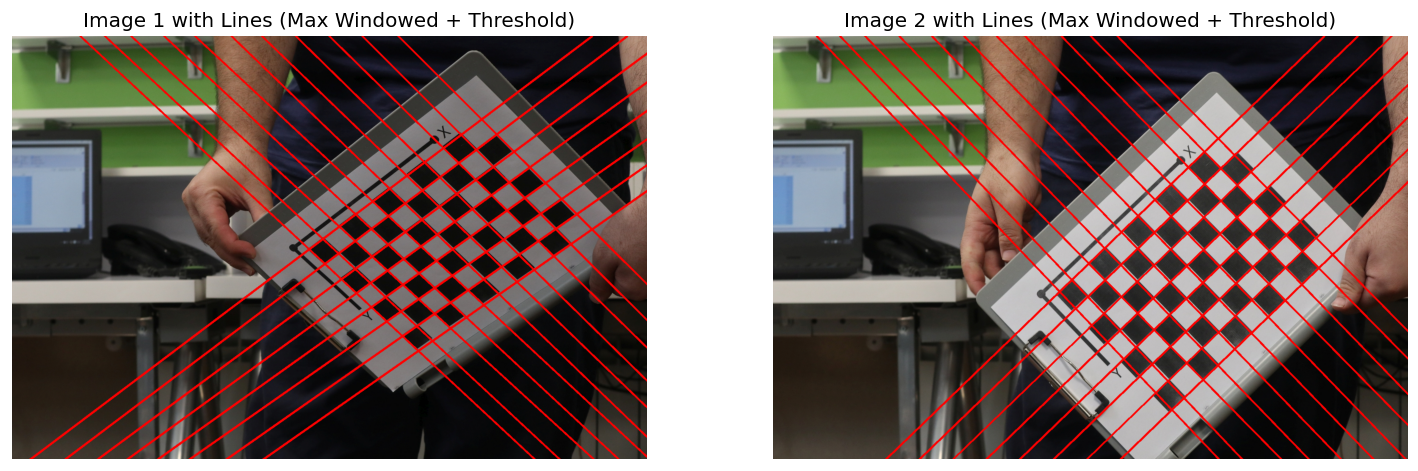

In [25]:
out1 = line_drawer(im1, hough1_cleaned, dtheta, dr, color=(255,0,0), thickness=4)
out2 = line_drawer(im2, hough2_cleaned, dtheta, dr, color=(255,0,0), thickness=4)

plt.figure(dpi=120,figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(out1.astype("uint8"))
plt.axis("off")
plt.title("Image 1 with Lines (Max Windowed + Threshold)")

plt.subplot(1,2,2)
plt.imshow(out2.astype("uint8"))
plt.axis("off")
plt.title("Image 2 with Lines (Max Windowed + Threshold)")
plt.show()

In [26]:
Image.fromarray(out1.astype("uint8")).save("results/res07-chess.jpg", "JPEG")
Image.fromarray(out2.astype("uint8")).save("results/res08-chess.jpg", "JPEG")

## Part 4: Finding the Corners

In [27]:
# we find the lowest and highest rhos in values that have approximately equal thetas
locs1 = np.where(hough1_cleaned == 1)
locs1_tuple = list(zip(locs1[0] * dr - r_max, locs1[1] * dtheta - 90))
locs1_tuple

[(-647.7756377319947, -45.0),
 (-587.7756377319947, -45.0),
 (-527.7756377319947, -44.5),
 (-472.7756377319947, -44.5),
 (-412.7756377319947, -44.0),
 (-362.7756377319947, -44.0),
 (-297.7756377319947, -43.0),
 (-247.77563773199472, -43.0),
 (-192.77563773199472, -42.5),
 (-152.77563773199472, -43.0),
 (-112.77563773199472, -43.0),
 (822.2243622680053, 37.0),
 (872.2243622680053, 37.0),
 (922.2243622680053, 36.5),
 (967.2243622680053, 36.0),
 (1012.2243622680053, 35.5),
 (1057.2243622680053, 35.0),
 (1107.2243622680053, 35.0),
 (1157.2243622680053, 35.0)]

In [28]:
def point_finder(line1, line2, reversed_out = True):
    '''This function gets the rho and theta of two lines and find the point that is at the intersection of these
    lines.'''
    rho1, theta1 = line1
    rho2, theta2 = line2
    theta1 = theta1 * np.pi / 180
    theta2 = theta2 * np.pi / 180
    x = (rho1/np.sin(theta1) - rho2/np.sin(theta2)) / (np.cos(theta1)/np.sin(theta1) - np.cos(theta2)/np.sin(theta2))
    y = (rho1 - x*np.cos(theta1))/np.sin(theta1)
    if (reversed_out):
        return (int(y), int(x))
    return (int(x),int(y))

In [29]:
# selecting the four desired rho, theta values 
line1_1 = locs1_tuple[0]
line1_2 = locs1_tuple[10]

line2_1 = locs1_tuple[11]
line2_2 = locs1_tuple[18]

In [30]:
# finding the corners
point1 = point_finder(line1_1,line2_1)
point2 = point_finder(line1_1,line2_2)
point3 = point_finder(line1_2,line2_1)
point4 = point_finder(line1_2,line2_2)

In [31]:
# drawing the corners on the image
im1_corners = cv.circle(im1, point1, 7, (0,255,0), -1)
im1_corners = cv.circle(im1_corners, point2, 7, (0,255,0), -1)
im1_corners = cv.circle(im1_corners, point3, 7, (0,255,0), -1)
im1_corners = cv.circle(im1_corners, point4, 7, (0,255,0), -1).astype("uint8")

In [32]:
# doing the same for image 2
locs2 = np.where(hough2_cleaned == 1)
locs2_tuple = list(zip(locs2[0] * dr - r_max, locs2[1] * dtheta - 90))
locs2_tuple

[(-582.7756377319947, -45.5),
 (-537.7756377319947, -45.5),
 (-492.7756377319947, -46.0),
 (-427.7756377319947, -45.5),
 (-382.7756377319947, -46.0),
 (-327.7756377319947, -46.0),
 (-272.7756377319947, -46.0),
 (-217.77563773199472, -46.0),
 (-157.77563773199472, -45.5),
 (-117.77563773199472, -46.5),
 (-77.77563773199472, -46.5),
 (902.2243622680053, 44.0),
 (957.2243622680053, 44.0),
 (1012.2243622680053, 44.0),
 (1067.2243622680053, 44.0),
 (1122.2243622680053, 44.0),
 (1177.2243622680053, 44.0),
 (1232.2243622680053, 44.0),
 (1287.2243622680053, 44.0)]

In [33]:
# selecting the four desired rho, theta values 
line1_1 = locs2_tuple[0]
line1_2 = locs2_tuple[10]

line2_1 = locs2_tuple[11]
line2_2 = locs2_tuple[18]

In [34]:
# finding the corners
point1 = point_finder(line1_1,line2_1)
point2 = point_finder(line1_1,line2_2)
point3 = point_finder(line1_2,line2_1)
point4 = point_finder(line1_2,line2_2)

In [35]:
# drawing the corners on the image
im2_corners = cv.circle(im2, point1, 7, (0,255,0), -1)
im2_corners = cv.circle(im2_corners, point2, 7, (0,255,0), -1)
im2_corners = cv.circle(im2_corners, point3, 7, (0,255,0), -1)
im2_corners = cv.circle(im2_corners, point4, 7, (0,255,0), -1).astype("uint8")

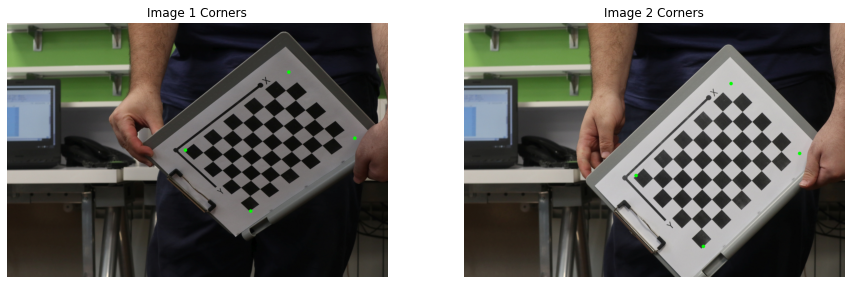

In [36]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.title("Image 1 Corners")
plt.imshow(im1_corners)
plt.axis("off")
plt.subplot(1,2,2)
plt.title("Image 2 Corners")
plt.imshow(im2_corners)
plt.axis("off")
plt.show()

In [37]:
Image.fromarray(im1_corners.astype("uint8")).save("results/res09-corners.jpg", "JPEG")
Image.fromarray(im2_corners.astype("uint8")).save("results/res10-corners.jpg", "JPEG")